
<a href="https://colab.research.google.com/github/SMTorg/smt/blob/master/tutorial/SMT_PODI_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div class="jumbotron text-left"><b>

This tutorial describes how to use PODI, an application of the SMT toolbox. It combines Proper Orthogonal Decomposition (POD) and kriging based surrogate models to perform the estimations of vectorial outputs
</div>

Hugo Reimeringer ONERA/DTIS/M2CI

July  2024 - `SMT version 2.6.2`
</b>

<p class="alert alert-success" style="padding:1em">
To use SMT, please follow this link : https://github.com/SMTorg/SMT/blob/master/README.md. The documentation is available here: http://smt.readthedocs.io/en/latest/
</p>

The reference paper is available
here https://www.sciencedirect.com/science/article/pii/S0965997818309360?via%3Dihub

or as a preprint: http://mdolab.engin.umich.edu/content/python-surrogate-modeling-framework-derivatives

In [1]:
%pip install smt

Note: you may need to restart the kernel to use updated packages.


# Context
---

We consider a problem in which the estimation of a vectorial output $u\in\mathbb{R}^p$ is desired.
This vector depends of an input variable $\mathbf{x}=(\mathbf{x_1},\dots,\mathbf{x_N})\in\mathbb{R}^N$ representing the caracteristics of $N$ configurations of the problem.
With $k \in [\![1,N]\!]$, $u(\mathbf{x_k})$ corresponds to output values at a specific configuration. It is called a **snapshot**.

The $N$ snapshots are gathered in a database called the **snapshot matrix**:
$$
	S=
	\begin{bmatrix}
		u( \mathbf{x}_1)_1 & \dots & u( \mathbf{x}_N)_1 \\
		\vdots & \ddots & \vdots \\
		u( \mathbf{x}_1)_p & \dots & u( \mathbf{x}_N)_p \\
	\end{bmatrix}
	\in \mathbb{R}^{p \times N}
$$

Each column of the matrix corresponds to a snapshot $u(\mathbf{x_k})$.

We import the needed packages

In [2]:
from smt.applications import PODI
import numpy as np
from scipy import special
from matplotlib import pyplot as plt
from smt.sampling_methods import LHS

%matplotlib inline
# to ignore warning messages
import warnings

warnings.filterwarnings("ignore")

# 1D test function

In [3]:
# defining the 1D-test fuction

p = 100
y = np.linspace(-1, 1, p)
n_modes_test = 10


def function_test_1d(x, y, n_modes_test, p):
    def cos_coeff(i: int, x: np.ndarray):
        a = 2 * i % 2 - 1
        return a * x[:, 0] * np.cos(i * x[:, 0])

    def Legendre(i: int, y: np.ndarray):
        return special.legendre(i)(y)

    def gram_schmidt(input_array: np.ndarray) -> np.ndarray:
        """To perform the  Gram-Schmidt's algorithm."""

        basis = np.zeros_like(input_array)
        for i in range(len(input_array)):
            basis[i] = input_array[i]
            for j in range(i):
                basis[i] -= (
                    np.dot(input_array[i], basis[j])
                    / np.dot(basis[j], basis[j])
                    * basis[j]
                )
            basis[i] /= np.linalg.norm(basis[i])
        return basis

    u0 = np.zeros((p, 1))

    alpha = np.zeros((x.shape[0], n_modes_test))
    for i in range(n_modes_test):
        alpha[:, i] = cos_coeff(i, x)

    V_init = np.zeros((p, n_modes_test))
    for i in range(n_modes_test):
        V_init[:, i] = Legendre(i, y)

    V = gram_schmidt(V_init.T).T
    database = u0 + np.dot(V, alpha.T)

    return database


seed_sampling = 42
xlimits = np.array([[0, 4]])
sampling = LHS(xlimits=xlimits, random_state=seed_sampling)

nt = 40
xt = sampling(nt)

nv = 50
xv = sampling(nv)

x = np.concatenate((xt, xv))
dbfull = function_test_1d(x, y, n_modes_test, p)

# Training data
dbt = dbfull[:, :nt]

# Validation data
dbv = dbfull[:, nt:]

# Proper Orthogonal Decomposition (POD)
---

The vectorial output $u$ is a vector of dimension $p$. Its POD is this decomposition:

$$
	u({\mathbf x})=u_0 + \sum_{i=1}^{M} \alpha_i(\mathbf x)\phi_i
$$

* $u$ is decomposed as a sum of $M$ modes and $u_0$ corresponds to the mean value of $u$.

* each mode $i$ is defined by a scalar coefficient $\alpha_i$ and a vector $\phi_{i}$ of dimension $p$.

* the $\phi_i$ vectors are orthogonal and form the **POD basis**.

We can also define the matricial POD equation:

$$
	S=U_0+\Phi A
$$

where $U_0$ is composed of the $u_0$ vector on each column,

$$
	A=
	\begin{bmatrix}
		\alpha_1( \mathbf{x}_1) & \dots & \alpha_1( \mathbf{x}_N) \\
		\vdots & \ddots & \vdots \\
		\alpha_M( \mathbf{x}_1) & \dots & \alpha_M( \mathbf{x}_N) \\
	\end{bmatrix}
	,\Phi=
	\begin{bmatrix}
		(\phi_1)_1 & \dots & (\phi_M)_1 \\
		\vdots & \ddots & \vdots \\
		(\phi_1)_p & \dots & (\phi_M)_p \\
	\end{bmatrix}
$$

# Singular Values Decomposition (SVD)
---

To perform the POD, the SVD of the snapshot matrix *S* is used:

$$
	S=U\Sigma{V}^{T}
$$

The $(p \times p)$ $U$ and $(N \times N)$ ${V}^{T}$ matrices are orthogonal and contain the **singular vectors**.
These vectors are the directions of maximum variance in the data and are ranked by decreasing order of importance.
Each vector corresponds to a mode of $u$. The total number of available modes is limited by the number of snapshots:

$$
	M \le N
$$

The importance of each mode is represented by the diagonal values of the $(p \times N)$ $\Sigma$ matrix. They are known as the **singular values** $\sigma_i$ and are positive numbers ranked by decreasing value.
It is then needed to filter the modes to keep those that represent most of the data structure.
To do this, we use the **explained variance** (EV). It represents the data variance that we keep when filtering the modes.

If $m$ modes are kept, their explained variance $EV_m$ is:

$$
	EV_m=\frac{\sum_{i=1}^{m} \sigma_i}{\sum_{i=1}^{N} \sigma_i}
$$

The number of kept modes is defined by a tolerance $\eta \in ]0,1]$ that represents the minimum variance we desire to explain during the SVD:

$$
	M = \min\{m \in [\![1,N]\!]: EV_m \ge \eta\}
$$

Then, the first $M$ singular vectors of the $U$ matrix correspond to the $\phi_i$ vectors in the POD.
The $\alpha_i$ coefficients of the $A$ matrix can be deduced:

$$
	A={\Phi}^{T}(S-U_0)
$$

### Computing the POD

In [4]:
# Call PODI
podi = PODI()
seed_pod = 42
podi.compute_pod(database=dbt, tol=0.9999, seed=seed_pod)

# Results of the POD + SVD
n_modes = podi.get_n_modes()
print(f"{n_modes} modes were kept.")

10 modes were kept.


# Use of Surrogate models
---

To compute $u$ at a new input $\mathbf{x}_*$, the values of $\alpha_i(\mathbf{x}_*)$ at each mode $i$ are needed.

To estimate them, **kriging based surrogate models** are used:

$$
	\mathbf{x}=(\mathbf{x}_1,\dots,\mathbf{x}_k,\dots,\mathbf{x}_N)
	\longrightarrow
	\begin{cases}
		\alpha_1(\mathbf{x}) \longrightarrow \text{model 1} \\
		\vdots \\
		\alpha_i(\mathbf{x}) \longrightarrow \text{model i} \\
		\vdots \\
		\alpha_M(\mathbf{x}) \longrightarrow \text{model M} \\
	\end{cases}
$$

For each kept mode $i$, we use a surrogate model that is trained with the inputs $\mathbf{x}_k$ and outputs $\alpha_i(\mathbf{x}_k)$.

These models are able to compute an estimation denoted $\hat\alpha_i(\mathbf{x}_*)$. It is normally distributed:

$$
	\hat\alpha_i(\mathbf{x}_*) \hookrightarrow \mathcal{N}(\mu_i(\mathbf{x}_*),\sigma_i^{2}(\mathbf{x}_*))
$$

The mean, variance and derivative of $u(\mathbf{x}_*)$ can be deduced:

$$
	\begin{cases}
		\mathbb{E}[u(\mathbf{x}_*)]=u_0+\sum_{i=1}^{M} \mu_i(\mathbf{x}_*)\phi_i \\
		\mathbb{V}[u(\mathbf{x}_*)]=\sum_{i=1}^{M} \sigma_i^{2}(\mathbf{x}_*)\phi_i^{2} \\
		u'(\mathbf{x}_*)=\sum_{i=1}^{M} \alpha_i'(\mathbf{x}_*)\phi_i
	\end{cases}
$$

NB: The variance equation takes in consideration that:

- the models are pairwise independent, so are the coefficients $\hat\alpha_i(\mathbf{x}_*)$.

### Setting the models to perform the predictions

In [5]:
# Choosing the KPLSK models (default is Kriging "KRG")
# Choosing the correlation kernel  (default is "squar_exp")
# Choosing the optimizer for Hyperparameters  (default is "TNC")

podi.set_interp_options(
    interp_type="KPLSK", interp_options=[{"corr": "matern52", "hyper_opt": "Cobyla"}]
)

# Setting the training values
podi.set_training_values(xt=xt)

# Training the models
podi.train()

# predicting the desired values with inputs
values = podi.predict_values(xv)
variances = podi.predict_variances(xv)
derivatives = podi.predict_derivatives(xv, kx=0)

### Results for an input $x_*$ not used for the training

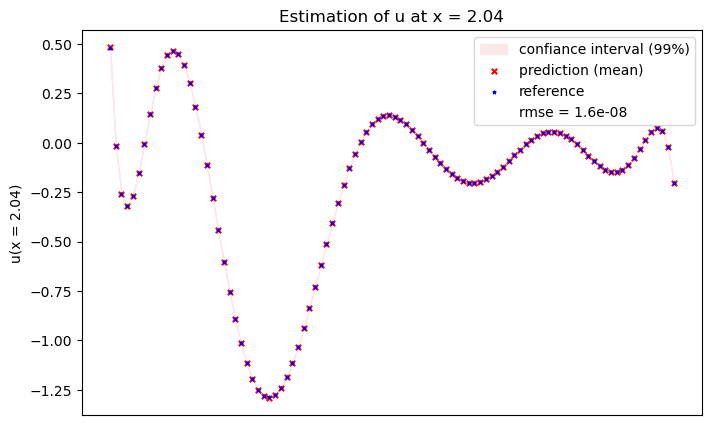

In [6]:
# Choosing a value from the validation inputs
i = nv // 2

diff = dbv[:, i] - values[:, i]
rms_error = np.sqrt(np.mean(diff**2))
plt.figure(figsize=(8, 5))
light_pink = np.array((250, 233, 232)) / 255
plt.fill_between(
    np.ravel(y),
    np.ravel(values[:, i] - 3 * np.sqrt(variances[:, i])),
    np.ravel(values[:, i] + 3 * np.sqrt(variances[:, i])),
    color=light_pink,
    label="confiance interval (99%)",
)
plt.scatter(
    y,
    values[:, i],
    color="r",
    marker="x",
    s=15,
    alpha=1.0,
    label="prediction (mean)",
)
plt.scatter(
    y,
    dbv[:, i],
    color="b",
    marker="*",
    s=5,
    alpha=1.0,
    label="reference",
)
plt.plot([], [], color="w", label="rmse = " + str(round(rms_error, 9)))

ax = plt.gca()
ax.axes.xaxis.set_visible(False)

plt.ylabel("u(x = " + str(xv[i, 0])[:4] + ")")
plt.title("Estimation of u at x = " + str(xv[i, 0])[:4])
plt.legend()
plt.show()

# POD errors
---

During the computing of the POD, several numerical errors appear:

## Projection error:

After the SVD step, the $\alpha_i$ coefficients are calculated with the projection equation:

$$
	A\approx \Phi^T.(S-U_0)
$$
Because of the approximation, there is a difference between the computed $\alpha_i$ and the actual coefficients. This is the projection error.

## Interpolation error:

When the $\alpha_i$ coefficients are computed for the training values $x_1,\dots,x_k,\dots,x_N$, an interpolation of these values is made by the surrogate models to calculate an estimation $\hat\alpha_i(x_*)$. This prediction is different from the actual values $\alpha_i(x_*)$. It corresponds to the interpolation error.

## Total error:

The accumulation of the projection and the interpolation leads to the total error.

### Computing the POD errors
Please note that the computation times are very long for the POD errors

In [7]:
[interp_error, proj_error, tot_error] = podi.compute_pod_errors(xt=xt, database=dbt)
print("interpolation error", interp_error)
print("projection error", proj_error)
print("total error", tot_error)

interpolation error 0.0012723131820283568
projection error 2.2076648468192347e-15
total error 0.0007945593275101975


# Local POD
---
In the last parts, the POD equation was:
$$
	u({\mathbf x})=u_0 + \sum_{i=1}^{M} \alpha_i(\mathbf x)\phi_i
$$
In the first part, the $\phi_i$ vectors are independents of $\mathbf{x}=(\mathbf{x_1},\dots,\mathbf{x_N})$. It was a $global$ POD: the POD basis is the same for every snapshot.

Here is the local POD equation:
$$
	u({\mathbf x})=u_0 + \sum_{i=1}^{M} \alpha_i(\mathbf x)\phi_i(\mathbf x^{(j)})
$$
Where $x^{(j)}$ is the j-th element of $x_1,\dots,x_N$

In this version of the POD, the $\phi_i$ vectors depend of the $\mathbf x_j$ values of $\mathbf x$.


# 2D test function for local bases

In [8]:
# defining the 1D-test fuction

p = 100
y = np.linspace(-1, 1, p)
n_modes_test = 10


def function_test_2d_local(x, y, n_modes_test, p):
    def cos_coeff_nd(i: int, x: np.ndarray):
        a = 2 * i % 2 - 1
        return a * sum(x.T) * np.cos(i * sum(x.T))

    def Legendre(i: int, y: np.ndarray):
        return special.legendre(i)(y)

    def gram_schmidt(input_array: np.ndarray) -> np.ndarray:
        """To perform the  Gram-Schmidt's algorithm."""

        basis = np.zeros_like(input_array)
        for i in range(len(input_array)):
            basis[i] = input_array[i]
            for j in range(i):
                basis[i] -= (
                    np.dot(input_array[i], basis[j])
                    / np.dot(basis[j], basis[j])
                    * basis[j]
                )
            basis[i] /= np.linalg.norm(basis[i])
        return basis

    u0 = np.zeros((p, 1))

    alpha = np.zeros((x.shape[0], n_modes_test))
    for i in range(n_modes_test):
        alpha[:, i] = cos_coeff_nd(i, x)

    V_init = np.zeros((p, n_modes_test))
    for i in range(n_modes_test):
        V_init[:, i] = Legendre(i, y)

    V = gram_schmidt(V_init.T).T
    database = u0 + np.dot(V, alpha.T)

    return database


seed = 42
xlimits = [[0, 1], [0, 4]]
sampling_x1 = LHS(xlimits=np.array([xlimits[0]]), random_state=seed)
sampling_x2 = LHS(xlimits=np.array([xlimits[1]]), random_state=seed + 1)

nt1 = 25
nt2 = 10
nt = nt1 * nt2
xt1 = sampling_x1(nt1)
xt2 = sampling_x2(nt)
xt = np.zeros((nt, 2))
xt[:, 1] = xt2[:, 0]
for i, elt in enumerate(xt1):
    xt[i * nt2 : (i + 1) * nt2, 0] = elt

sampling_new = LHS(xlimits=np.array(xlimits), random_state=seed)

nv = 15
xv = sampling_new(nv)
xv1 = np.atleast_2d(xv[:, 0]).T
x = np.concatenate((xt, xv))

dbfull = function_test_2d_local(x, y, n_modes_test, p)

# Training data
dbt = dbfull[:, :nt]

# Validation data
dbv = dbfull[:, nt:]

## View of the DoE in 2D:

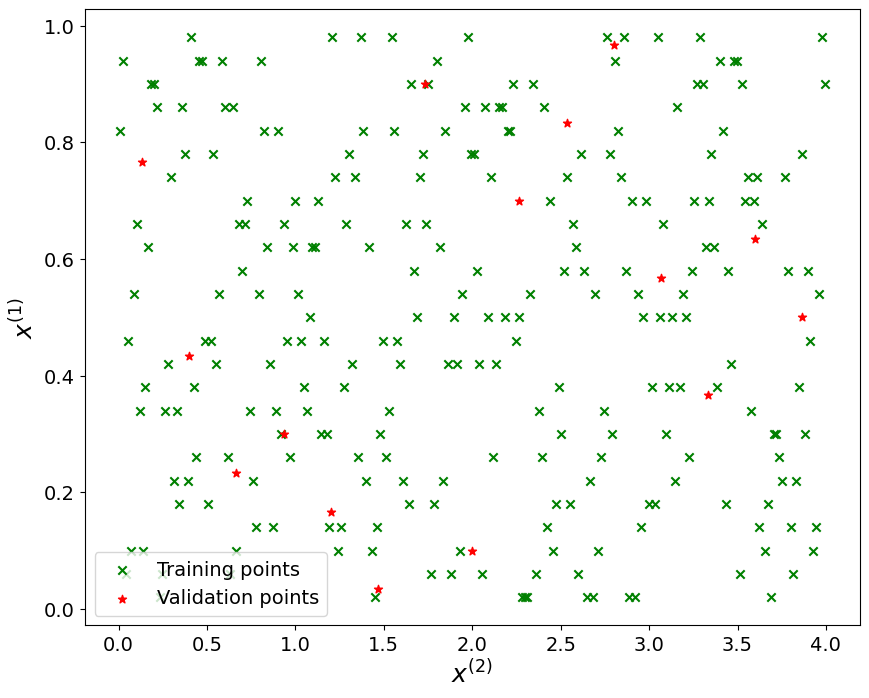

In [9]:
plt.figure(figsize=(10, 8))
axes = plt.gca()
axes.tick_params(axis="x", labelsize=14)
axes.tick_params(axis="y", labelsize=14)
plt.scatter(xt[:, 1], xt[:, 0], marker="x", label="Training points", color="g")
plt.scatter(xv[:, 1], xv[:, 0], marker="*", label="Validation points", color="r")
plt.xlabel(r"$x^{(2)}$", fontsize=18)
plt.ylabel(r"$x^{(1)}$", fontsize=18)
plt.legend(loc="lower left", fontsize=14)
plt.show()

### Computing of the local bases corresponding to each line of the DoE:

In [10]:
tol = 0.9999  # SVD tolerance for each line's POD basis
local_pod_bases = []  # list of each line's POD bases
n_modes_list = []

podi = PODI()
for i in range(nt1):
    db_loc = dbt[:, i * nt2 : (i + 1) * nt2]
    podi.compute_pod(db_loc, pod_type="global", n_modes=min(db_loc.shape), seed=i)
    ev_list = podi.get_ev_list()

    n_modes = PODI.choice_n_modes_tol(ev_list, tol)
    n_modes_list.append(n_modes)

    local_basis = podi.get_basis()
    local_pod_bases.append(local_basis)

### For each validation point, estimation of the interpolated basis at $x^{(1)}$

In [11]:
# Function that choose the 'n_bases' closest bases (closest value of x^(1))
# and use 'interp_subspaces' to estimate a new basis
n_bases = 10


def choose_local_bases(local_pod_bases, n_bases, modes_list):
    interpolated_bases = []
    keep_index_list = []
    max_modes_list = []

    for value in xv1:
        sorted_ind = sorted(
            range(xt1.shape[0]), key=lambda k: abs(xt1[:, 0] - value)[k]
        )
        keep_index = sorted_ind[:n_bases]
        keep_index_list.append(keep_index)
        input_matrices = []
        keep_xt1 = []
        max_modes = max(modes_list[keep_index])
        max_modes_list.append(max_modes)
        for i in keep_index:
            input_matrices.append(local_pod_bases[i][:, :max_modes])
            keep_xt1.append(xt1[i, 0])
        basis = PODI.interp_subspaces(
            xt1=np.atleast_2d(keep_xt1).T,
            input_matrices=input_matrices,
            xn1=np.atleast_2d(value),
            frechet=True,
            print_global=False,
        )
        interpolated_bases.append(basis[0])
    return interpolated_bases, keep_index_list


interpolated_bases, keep_index_list = choose_local_bases(
    local_pod_bases, n_bases=n_bases, modes_list=np.array(n_modes_list)
)

### Computing the POD for a specific validation point

In [12]:
# Choosing a value from the validation inputs
i = 0

podi = PODI()
j = []
for ind in keep_index_list[i]:
    j += list(range(ind * nt2, (ind + 1) * nt2))
podi.compute_pod(
    database=dbt[:, j], pod_type="local", local_basis=interpolated_bases[i]
)
n_modes = podi.get_n_modes()
print(f"{n_modes} modes were kept.")

8 modes were kept.


### Setting the models

In [13]:
# Choosing the default interp options
# Setting the training values
podi.set_training_values(xt=np.atleast_2d(xt[j]))

# Training the models
podi.train()

# predicting the desired values with inputs
values = podi.predict_values(np.atleast_2d(xv[i]))

### Showing the results

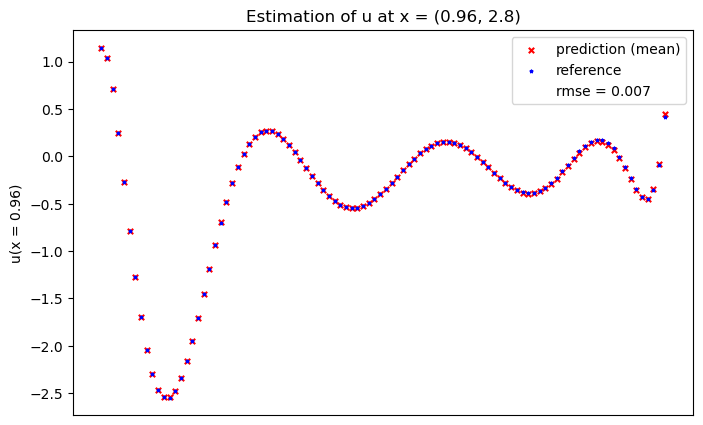

In [14]:
diff = dbv[:, i] - values[:, 0]

rms_error = np.sqrt(np.mean(diff**2))
plt.figure(figsize=(8, 5))
light_pink = np.array((250, 233, 232)) / 255
plt.scatter(
    y,
    values,
    color="r",
    marker="x",
    s=15,
    alpha=1.0,
    label="prediction (mean)",
)
plt.scatter(
    y,
    dbv[:, i],
    color="b",
    marker="*",
    s=5,
    alpha=1.0,
    label="reference",
)
plt.plot([], [], color="w", label="rmse = " + str(round(rms_error, 5)))

ax = plt.gca()
ax.axes.xaxis.set_visible(False)

plt.ylabel("u(x = " + str(xv[i, 0])[:4] + ")")
plt.title(f"Estimation of u at x = ({str(xv[i, 0])[:4]}, {str(xv[i, 1])[:4]})")
plt.legend()
plt.show()